# Stat 504 HW 3

Note: For Data Set #2 (reviews_Musical_Instruments.json), please download the file here: https://dl.dropboxusercontent.com/u/102059479/reviews_Musical_Instruments.json

In [9]:
# import modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import datasets
from sklearn.feature_selection import RFE
import time
%matplotlib inline

# Data set #2: Musical Instruments

In [2]:
# read json into a DataFrame locally
# reference: https://www.reddit.com/r/MachineLearning/comments/33eglq/python_help_jsoncsv_pandas/

with open('reviews_Musical_Instruments.json', 'rb') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
data_df = pd.read_json(data_json_str)
data_df.head(3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800


In [3]:
data_df.shape

(189653, 9)

In [4]:
# select response variables is the reviewer’s rating in "overall": 5.0 versus 1.0
review_best_worst = data_df[(data_df.overall==5) | (data_df.overall==1)]
review_best_worst.shape

(131960, 9)

In [5]:
# record_best_worst = review_best_worst[:10000]
record_best_worst = review_best_worst

X = record_best_worst.reviewText
y = record_best_worst.overall
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)

vect = CountVectorizer(max_features = 1000)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

## Model hyper-parameters optimization

### tuning n_neighbor for KNN

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)
{'n_neighbors': 1}
[ 0.87977369  0.88098606  0.88330976  0.88330976  0.87582096  0.87713449
  0.88278092  0.88005255  0.88298302  0.88116411]
0.880731534809
[0.88073153480852784, 0.84775184399312919, 0.90772961503485905, 0.90367788218652112, 0.91248863291906634, 0.91206426189754475, 0.91274123471759117, 0.91358997676063458, 0.91256946549459428, 0.913438415681519

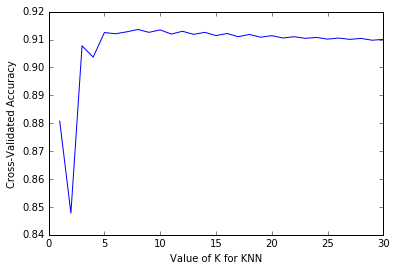

In [21]:
start = time.time()
knn = KNeighborsClassifier()
# define the parameter values that should be searched
k_range = range(1, 31)
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print param_grid
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# fit the grid with data
print grid.fit(train_dtm, y_train)
# view the complete results (list of named tuples)
grid.grid_scores_
# examine the first tuple
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores
# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
end = time.time()
knn_time = end - start
print "duration: %fs" % (knn_time)

In [22]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.913589976761
{'n_neighbors': 8}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=8, p=2, weights='uniform')


### tuning C for Logistic Regression

{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)
{'C': 1}
[ 0.94817135  0.9523136   0.95544554  0.94908062  0.9521067   0.95079317
  0.9507882   0.94735247  0.95048504  0.95220291]
0.950874002223
[0.95087400222289586, 0.95097504294230573, 0.95094473072648278, 0.95091441851065983, 0.95087400222289586, 0.95085379407901383, 0.95083358593513

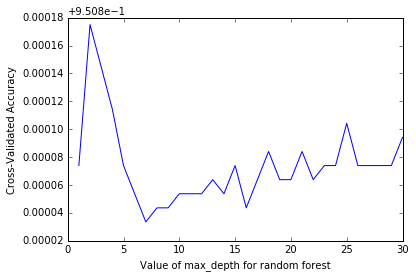

In [23]:
start = time.time()

model = LogisticRegression()
# model.fit(X_train, y_train)
# define the parameter values that should be searched
test_range = range(1, 31)
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=test_range)
print param_grid
# instantiate the grid
grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
# fit the grid with data
print grid.fit(train_dtm, y_train)
# view the complete results (list of named tuples)
grid.grid_scores_
# examine the first tuple
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores
# plot the results
plt.plot(test_range, grid_mean_scores)
plt.xlabel('Value of max_depth for random forest')
plt.ylabel('Cross-Validated Accuracy')

end = time.time()
logi_time = end - start
print "duration: %fs" % (logi_time)

In [24]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.950975042942
{'C': 2}
LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


### tuning max_depth for Classification Tree

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)
{'max_depth': 1}
[ 0.91109315  0.91169933  0.91270964  0.91099212  0.91169041  0.91088209
  0.91168149  0.90966047  0.90935732  0.91077203]
0.911053854703
[0.91105385470344546, 0.91471152874608463, 0.91578256037182981, 0.91582297665959378, 0.91637870061634841, 0.91662119834293221, 0.91694452864504394, 0.91758108517732651, 0.919763

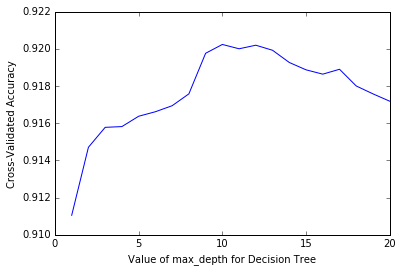

In [25]:
start = time.time()

model = DecisionTreeClassifier()
# define the parameter values that should be searched
test_range = range(1, 21)
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(max_depth=test_range)
print param_grid
# instantiate the grid
grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
# fit the grid with data
print grid.fit(train_dtm, y_train)
# view the complete results (list of named tuples)
grid.grid_scores_
# examine the first tuple
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores
# plot the results
plt.plot(test_range, grid_mean_scores)
plt.xlabel('Value of max_depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

end = time.time()
tree_time = end - start
print "duration: %fs" % (tree_time)

In [26]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.920238456098
{'max_depth': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')


### tuning n_estimators for Random Forest

{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)
{'n_estimators': 1}
[ 0.88139018  0.87320671  0.87775308  0.87886442  0.87390118  0.87582096
  0.87722312  0.8801536   0.87651576  0.87550525]
0.877

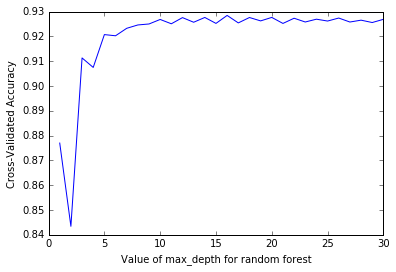

In [27]:
start = time.time()
model = RandomForestClassifier()
# define the parameter values that should be searched
test_range = range(1, 31)
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=test_range)
print param_grid
# instantiate the grid
grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
# fit the grid with data
print grid.fit(train_dtm, y_train)
# view the complete results (list of named tuples)
grid.grid_scores_
# examine the first tuple
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores
# plot the results
plt.plot(test_range, grid_mean_scores)
plt.xlabel('Value of max_depth for random forest')
plt.ylabel('Cross-Validated Accuracy')
end = time.time()
forest_time = end - start
print "duration: %fs" % (forest_time)

In [28]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.928493482874
{'n_estimators': 16}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### tuning n_estimators for Boosted Trees

{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)
{'n_estimators': 1}
[ 0.91109315  0.91169933  0.91270964  0.91099212  0.91169041  0.91088209
  0.91168149  0.90966047  0.90935732  0.91077203]
0.911053854703
[0.91105385470344546, 0.91158937051631805, 0.91134687278973425, 0.91486308982519959, 0.91606547438617758, 0.91611599474588257, 0.91632818025664342, 0.91644942911993532, 0.91637870061634841, 0.91677275942204706, 0.91838941

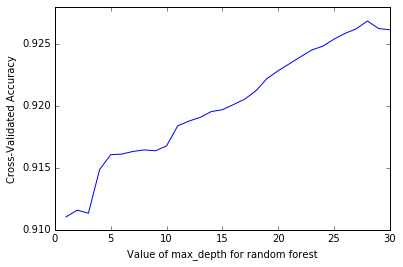

In [29]:
start = time.time()

model = AdaBoostClassifier()
# define the parameter values that should be searched
test_range = range(1,31)
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=test_range)
print param_grid
# instantiate the grid
grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
# fit the grid with data
print grid.fit(train_dtm, y_train)
# view the complete results (list of named tuples)
grid.grid_scores_
# examine the first tuple
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores
# plot the results
plt.plot(test_range, grid_mean_scores)
plt.xlabel('Value of max_depth for random forest')
plt.ylabel('Cross-Validated Accuracy')

boost_time = end - start
print "duration: %fs" % (boost_time)

In [30]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.926846519147
{'n_estimators': 28}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=28, random_state=None)


In [ ]:
# 10-fold cross-validation with K=8 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=8)
scores1 = cross_val_score(knn, train_dtm, y_train, cv=10, scoring='accuracy')
print scores1
print score1.mean()

# ROC and AUC

AUC for Multinomial Naive Bayes: 0.924631	duration: 0.141000
AUC for Gaussian Naive Bayes: 	0.924631	duration: 0.093000


MemoryError: 

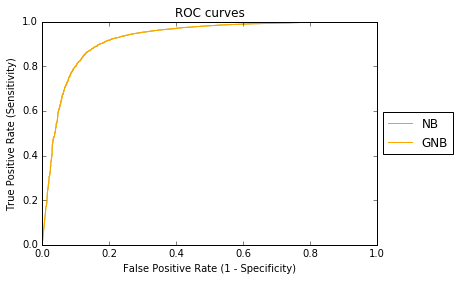

In [6]:
# Define a function to calculate AUC and plot ROC
def rocauc(method):
    #Xtrain = train_dtm; Xtest = test_dtm; 
    tit = 'ROC curves'
    global duration
    duration = 0
    start = time.time()
    # tit = 'ROC, feature=\'text\''
    if method == "reg":        
        model = LogisticRegression(C=2)
        tag = 'Logistic Regression'; col = 'b'
    elif method == "nb":        
        model = MultinomialNB()
        tag = 'NB'; col = 'y'
    elif method == "gnb":        
        model = MultinomialNB()
        tag = 'GNB'; col = 'orange'
    elif method == "knn":        
        model = KNeighborsClassifier(n_neighbors=8)
        tag = 'KNN (K=8)'; col = 'g'
    elif method == "tree":
        model = DecisionTreeClassifier(max_depth=10, random_state=1)
        tag = 'Classification Tree'; col = 'r'
    elif method == "svm-poly":
        model = SVC(kernel='poly', probability=True, degree=3)
        tag = 'SVM-poly'; col = 'grey'
    elif method == "rbf":
        model = SVC(kernel='rbf', probability=True)
        tag = 'rbf'; col = 'brown'
    elif method == "bagging":
        model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
        tag = 'Bagging'; col = '#015812'
    elif method == "forest":
        model = RandomForestClassifier(n_estimators=16)
        tag = 'Random Forest'; col = '#e21790'
    elif method == "boosted":
        model = AdaBoostClassifier(n_estimators=28)
        tag = 'Boosted Trees'; col = '#7a4234'
    # AUC values
    model.fit(train_dtm, y_train)
    y_pred_class = model.predict(test_dtm)
    y_pred_prob = model.predict_proba(test_dtm)[:, 1]
    y_test_binary = np.where(y_test==5, 1, 0)
    # ROC plot
    fpr, tpr, thresholds = metrics.roc_curve(y_test_binary, y_pred_prob)
    plt.plot(fpr, tpr, label=tag, color=col)
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5), numpoints = 1)
    plt.title(tit)
    # time calculate
    end = time.time()
    duration = end - start
    return metrics.roc_auc_score(y_test_binary, y_pred_prob)

print "AUC for Multinomial Naive Bayes: %f\tduration: %f" % (rocauc("nb"), duration)
print "AUC for Gaussian Naive Bayes: \t%f\tduration: %f" % (rocauc("gnb"), duration)
print "AUC for K-nearest Neighbors: \t%f\tduration: %f" % (rocauc("knn"), duration)
print "AUC for Logistic Regression: \t%f\tduration: %f" % (rocauc("reg"), duration)
print "AUC for SVM Polynomial Kernel: \t%f\tduration: %f" % (rocauc("svm-poly"), duration)
print "AUC for SVM Gaussian Kernel: \t%f\tduration: %f" % (rocauc("rbf"), duration)
print "AUC for Classification Tree: \t%f\tduration: %f" % (rocauc("tree"), duration)
print "AUC for Bagging: \t\t%f\tduration: %f" % (rocauc("bagging"), duration)
print "AUC for Random Forest: \t\t%f\tduration: %f" % (rocauc("forest"), duration)
print "AUC for Boosted Trees: \t\t%f\tduration: %f" % (rocauc("boosted"), duration)
plt.plot([0,1,1], 'black')

In [43]:
record_best_worst = review_best_worst[:10000]
# record_best_worst = review_best_worst

X = record_best_worst.reviewText
y = record_best_worst.overall
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)

vect = CountVectorizer(max_features = 1000)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

AUC for Multinomial Naive Bayes: 0.871943	duration: 0.307000
AUC for Gaussian Naive Bayes: 	0.871943	duration: 0.028000
AUC for K-nearest Neighbors: 	0.558127	duration: 3.470000
AUC for Logistic Regression: 	0.879774	duration: 1.001000
AUC for SVM Polynomial Kernel: 	0.806028	duration: 38.943000
AUC for SVM Gaussian Kernel: 	0.901784	duration: 37.839000
AUC for Classification Tree: 	0.663448	duration: 0.554000
AUC for Bagging: 		0.761055	duration: 14.465000
AUC for Random Forest: 		0.765560	duration: 1.072000
AUC for Boosted Trees: 		0.845402	duration: 1.718000


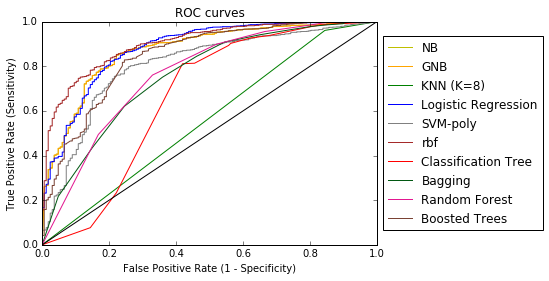

In [44]:
# Define a function to calculate AUC and plot ROC
def rocauc(method):
    #Xtrain = train_dtm; Xtest = test_dtm; 
    tit = 'ROC curves'
    global duration
    duration = 0
    start = time.time()
    # tit = 'ROC, feature=\'text\''
    if method == "reg":        
        model = LogisticRegression(C=2)
        tag = 'Logistic Regression'; col = 'b'
    elif method == "nb":        
        model = MultinomialNB()
        tag = 'NB'; col = 'y'
    elif method == "gnb":        
        model = MultinomialNB()
        tag = 'GNB'; col = 'orange'
    elif method == "knn":        
        model = KNeighborsClassifier(n_neighbors=8)
        tag = 'KNN (K=8)'; col = 'g'
    elif method == "tree":
        model = DecisionTreeClassifier(max_depth=10, random_state=1)
        tag = 'Classification Tree'; col = 'r'
    elif method == "svm-poly":
        model = SVC(kernel='poly', probability=True, degree=3)
        tag = 'SVM-poly'; col = 'grey'
    elif method == "rbf":
        model = SVC(kernel='rbf', probability=True)
        tag = 'rbf'; col = 'brown'
    elif method == "bagging":
        model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
        tag = 'Bagging'; col = '#015812'
    elif method == "forest":
        model = RandomForestClassifier(n_estimators=16)
        tag = 'Random Forest'; col = '#e21790'
    elif method == "boosted":
        model = AdaBoostClassifier(n_estimators=28)
        tag = 'Boosted Trees'; col = '#7a4234'
    # AUC values
    model.fit(train_dtm, y_train)
    y_pred_class = model.predict(test_dtm)
    y_pred_prob = model.predict_proba(test_dtm)[:, 1]
    y_test_binary = np.where(y_test==5, 1, 0)
    # ROC plot
    fpr, tpr, thresholds = metrics.roc_curve(y_test_binary, y_pred_prob)
    plt.plot(fpr, tpr, label=tag, color=col)
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5), numpoints = 1)
    plt.title(tit)
    # time calculate
    end = time.time()
    duration = end - start
    return metrics.roc_auc_score(y_test_binary, y_pred_prob)

print "AUC for Multinomial Naive Bayes: %f\tduration: %f" % (rocauc("nb"), duration)
print "AUC for Gaussian Naive Bayes: \t%f\tduration: %f" % (rocauc("gnb"), duration)
print "AUC for K-nearest Neighbors: \t%f\tduration: %f" % (rocauc("knn"), duration)
print "AUC for Logistic Regression: \t%f\tduration: %f" % (rocauc("reg"), duration)
print "AUC for SVM Polynomial Kernel: \t%f\tduration: %f" % (rocauc("svm-poly"), duration)
print "AUC for SVM Gaussian Kernel: \t%f\tduration: %f" % (rocauc("rbf"), duration)
print "AUC for Classification Tree: \t%f\tduration: %f" % (rocauc("tree"), duration)
print "AUC for Bagging: \t\t%f\tduration: %f" % (rocauc("bagging"), duration)
print "AUC for Random Forest: \t\t%f\tduration: %f" % (rocauc("forest"), duration)
print "AUC for Boosted Trees: \t\t%f\tduration: %f" % (rocauc("boosted"), duration)
plt.plot([0,1,1], 'black')

# Summary

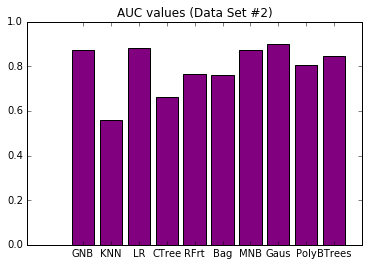

In [12]:
D = {u'MNB':0.871943, u'GNB': 0.871943, u'KNN':0.558127, u'LR':0.879774, u'Poly': 0.806028, \
     u'Gaus':0.901784, u'CTree':0.663448, u'Bag': 0.761055, u'RFrt':0.765560, u'BTrees':0.845402}

plt.bar(range(len(D)), D.values(), align='center', color='purple')
plt.xticks(range(len(D)), D.keys())
plt.title("AUC values (Data Set #2)")
plt.show()

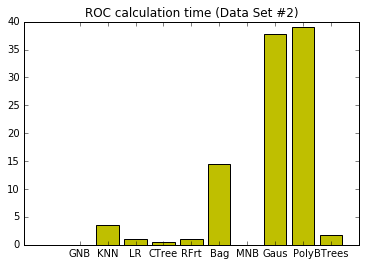

In [15]:
D = {u'MNB':0.037000, u'GNB': 0.028000, u'KNN':3.470000, u'LR':1.001000, u'Poly': 38.943000, \
     u'Gaus':37.839, u'CTree':0.554, u'Bag': 14.465, u'RFrt':1.072, u'BTrees':1.718000}

plt.bar(range(len(D)), D.values(), align='center', color='y')
plt.xticks(range(len(D)), D.keys())
plt.title("ROC calculation time (Data Set #2)")
plt.show()

## Conclusions:
1. In terms of AUC, SVM Gaussian Kernel (0.901784) is the best, followed by Logistic Regression (0.879774) and Naive Bayes (0.871943).
2. In terms of operation time, Gaussian Naive Bayes (0.028) is the best, followed by Multinomial Naive Bayes (0.307) and Classification Tree (0.554).
3. Generally speaking, Naive Bayes is considered to be the best machine learning method for Data Set #2.